
**Name:**  Eric Qiu

# Project 03: Critical Size and Enrichment in a Simple U-235 Reactor Model

## Introduction and Research Question

In a nuclear chain reaction, the multiplication factor $k$ describes how the number of neutrons changes from one generation to the next. When $k < 1$ the system is subcritical and the reaction dies out; when $k = 1$ it is critical and self-sustaining; and when $k > 1$ it is supercritical and the reaction grows. For a sample of U-235, whether $k$ is below, near, or above 1 depends on a combination of geometry, size, material properties, and isotopic enrichment.

In this project I use a Monte Carlo model of neutron transport and fission to investigate how **enrichment** (modeled as an effective fission probability) and **sample geometry** together determine whether a simple U-235 system can sustain a chain reaction. Neutrons are emitted from fission events, move in random directions through a finite sample, and are either absorbed inside the material or escape. Captured neutrons may cause new fissions, producing another generation of neutrons.

My central research question is:

> **How does the critical size of a U-235 sample depend on its effective enrichment $p$, and how does this relationship differ between a cube and a sphere of equal volume?**

To answer this, I will:
- Build and validate a 3D Monte Carlo simulation for a cubic U-235 sample, reproducing the example results from the project instructions.
- Introduce an **enrichment parameter** $p$, where each captured neutron causes fission with probability $p$.
- Systematically vary the cube side length $a$ and enrichment $p$, estimate $k$ across generations, and identify the approximate critical size where $k \approx 1$.
- Extend the model to compare a **cube and a sphere of equal volume**, to see how geometry alone affects $k$ at fixed material and volume.
- Validate the simulation with limiting cases and distribution checks, and justify my choices of parameters such as $N_0$, number of replications, and generations.


## Model and Methods

The simulation uses a simplified Monte Carlo model of U-235 fission. Neutrons are emitted from fission events, travel through the material in random directions, and either escape or are absorbed.

### Random directions and free paths

Neutron directions are sampled uniformly on the unit sphere. This is done by drawing a random azimuthal angle $\phi \in [0, 2\pi)$ and a uniform $\cos\theta \in [-1, 1]$, then converting to Cartesian components. The free path length $L$ is drawn from an exponential distribution with mean $\lambda = 2.65\ \text{cm}$:

$$
p(L) \propto e^{-L / \lambda}.
$$

### Geometry and absorption

The base fuel geometry is a cube of side length $a$. Neutrons start at random positions inside the cube, move a distance $L$ along their direction, and are classified as:

- **Escaped** if their final position lies outside $[0, a]^3$,  
- **Captured** if their final position remains inside the cube.  

Only captured neutrons can induce further fission.

Later in the project, I also consider a **sphere** with the same volume as a cube of side length $a$. In that case, the sphere has radius
$$
R(a) = \left(\frac{3 a^3}{4\pi}\right)^{1/3},
$$
and neutrons are started uniformly inside this sphere, with absorption defined by remaining inside radius $R$.

### Enrichment and fission probability

Enrichment is modeled by a parameter $p \in [0, 1]$, the probability that a captured neutron actually induces a fission event. For each captured neutron:

- With probability $p$, it induces fission and produces new neutrons.  
- With probability $1 - p$, it is absorbed without producing any children.  

In the simplified model, each fission event produces exactly 2 neutrons, created at the capture position of the parent neutron.

### Generations and the multiplication factor

The simulation proceeds in discrete generations: starting with $N_0$ neutrons, we propagate them, classify captures vs escapes, then spawn $N_1$ children from fissions, and so on up to $N_G$. The multiplication factor between generations $g$ and $g + 1$ is

$$
k_{g,g+1} = \frac{N_{g+1}}{N_g}.
$$

To estimate $k$, I perform many independent Monte Carlo replications and compute the mean, standard deviation, and standard error of $k_{g,g+1}$ across replications. Most of the analysis focuses on $k_{23}$, which is less sensitive to the random initial placement of the generation-0 neutrons and better reflects the “steady” behavior of the branching process.


In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Base physical/model parameters
MEAN_FREE_PATH = 2.65   # cm, simplified effective mean free path in U-235
NEUTRONS_PER_FISSION = 2.0 

# Default geometry: cube of side length a (cm)
DEFAULT_A = 10.0

np.random.seed(123)


In [2]:
# Random sampling helpers

def sample_initial_positions_in_cube(N, a):
    """
    Sample N random positions uniformly inside a cube [0, a]^3.

    Returns
    -------
    positions : array of shape (N, 3)
    """
    x = np.random.uniform(0.0, a, size=N)
    y = np.random.uniform(0.0, a, size=N)
    z = np.random.uniform(0.0, a, size=N)
    return np.column_stack((x, y, z))


def sample_random_directions(N):
    """
    Sample N random unit vectors uniformly on the unit sphere.

    Returns
    -------
    directions : array of shape (N, 3)
    """
    phi = np.random.uniform(0.0, 2.0 * np.pi, size=N)
    costheta = np.random.uniform(-1.0, 1.0, size=N)
    theta = np.arccos(costheta)

    sin_theta = np.sin(theta)
    dx = sin_theta * np.cos(phi)
    dy = sin_theta * np.sin(phi)
    dz = costheta

    return np.column_stack((dx, dy, dz))


def sample_free_paths(N, mean_free_path):
    """
    Sample N free path lengths from an exponential distribution with mean λ.

    Returns
    -------
    L : array of shape (N,)
    """
    return np.random.exponential(scale=mean_free_path, size=N)


In [3]:
# Geometry: cube and generic propagation

def inside_cube(positions, a):
    """
    Boolean mask for positions inside [0, a]^3.

    Parameters
    ----------
    positions : array, shape (N, 3)
    a : float

    Returns
    -------
    mask : array of bool, shape (N,)
    """
    x, y, z = positions[:, 0], positions[:, 1], positions[:, 2]
    return (
        (x >= 0.0) & (x <= a) &
        (y >= 0.0) & (y <= a) &
        (z >= 0.0) & (z <= a)
    )


def propagate_neutrons_cube(positions, directions, free_paths, a):
    """
    Propagate neutrons through a cube and return positions of absorbed neutrons.

    Parameters
    ----------
    positions : array, shape (N, 3)
    directions : array, shape (N, 3)
    free_paths : array, shape (N,)
    a : float

    Returns
    -------
    absorbed_positions : array, shape (N_absorbed, 3)
    """
    final_positions = positions + directions * free_paths[:, None]
    mask_inside = inside_cube(final_positions, a)
    absorbed_positions = final_positions[mask_inside]
    return absorbed_positions


In [5]:
# Fission and purity

def fission_children(absorbed_positions, purity, neutrons_per_fission):
    """
    Given absorbed neutron positions, decide which cause fission and spawn children.

    Parameters
    ----------
    absorbed_positions : array, shape (N_abs, 3)
    purity : float in [0, 1]
        Probability a capture actually induces fission.
    neutrons_per_fission : float
        Average number of neutrons per fission (rounded to nearest int here).

    Returns
    -------
    child_positions : array, shape (N_children, 3)
    """
    N_abs = absorbed_positions.shape[0]
    if N_abs == 0:
        return absorbed_positions[:0]  # empty (0, 3)

    # Which absorbed neutrons actually cause fission?
    fission_mask = np.random.random(size=N_abs) < purity
    fission_positions = absorbed_positions[fission_mask]
    N_fission = fission_positions.shape[0]

    if N_fission == 0:
        return fission_positions[:0]

    n_per = int(round(neutrons_per_fission))
    child_positions = np.repeat(fission_positions, repeats=n_per, axis=0)
    return child_positions


In [6]:
# One replication: cube geometry

def run_one_replication(
    N0,
    generations,
    a=DEFAULT_A,
    mean_free_path=MEAN_FREE_PATH,
    purity=1.0,
    neutrons_per_fission=NEUTRONS_PER_FISSION,
):
    """
    Run a single Monte Carlo replication of the chain reaction in a cube.

    Parameters
    ----------
    N0 : int
        Number of initial (generation 0) neutrons.
    generations : int
        Number of generations after N0 to simulate (e.g., 3 gives N0..N3).
    a : float
        Cube side length (cm).
    mean_free_path : float
    purity : float
    neutrons_per_fission : float

    Returns
    -------
    Ns : array, shape (generations + 1,)
        Neutron counts [N0, N1, ..., N_generations].
    """
    Ns = []

    # Generation 0
    positions = sample_initial_positions_in_cube(N0, a)
    Ns.append(len(positions))

    for g in range(generations):
        N = len(positions)
        if N == 0:
            Ns.extend([0] * (generations - g))
            break

        directions = sample_random_directions(N)
        free_paths = sample_free_paths(N, mean_free_path)
        absorbed_positions = propagate_neutrons_cube(positions, directions, free_paths, a)
        child_positions = fission_children(absorbed_positions, purity, neutrons_per_fission)

        Ns.append(len(child_positions))
        positions = child_positions

    return np.array(Ns, dtype=int)


In [7]:
# Estimating k statistics (cube)

def estimate_k_stats(
    N0,
    generations,
    m_rep,
    a=DEFAULT_A,
    mean_free_path=MEAN_FREE_PATH,
    purity=1.0,
    neutrons_per_fission=NEUTRONS_PER_FISSION,
):
    """
    Run many replications and estimate k_{g,g+1} statistics for cube geometry.

    Returns
    -------
    k_stats : dict
        Keys: (g, g+1).
        Values: dict with 'mean', 'std', 'stderr', 'values' (array length m_rep).
    """
    k_values = { (g, g+1): [] for g in range(generations) }

    for _ in range(m_rep):
        Ns = run_one_replication(
            N0=N0,
            generations=generations,
            a=a,
            mean_free_path=mean_free_path,
            purity=purity,
            neutrons_per_fission=neutrons_per_fission,
        )

        for g in range(generations):
            Ng = Ns[g]
            Ng1 = Ns[g + 1]
            if Ng > 0:
                k_values[(g, g+1)].append(Ng1 / Ng)
            else:
                k_values[(g, g+1)].append(0.0)

    k_stats = {}
    for key, vals in k_values.items():
        arr = np.array(vals)
        mean = np.mean(arr)
        std = np.std(arr, ddof=1)
        stderr = std / np.sqrt(m_rep)
        k_stats[key] = {
            'mean': mean,
            'std': std,
            'stderr': stderr,
            'values': arr,
        }

    return k_stats


## Results

### 4.1 Multiplication-factor distributions for a 10 cm cube

I first reproduced the reference case from the project instructions: a cube with side length $a = 10$ cm, initial neutron count $N_0 = 250$, and $m = 300$ replications, with purity fixed at $p = 1$. The goal is to confirm that the implementation produces $k_{01}$, $k_{12}$, and $k_{23}$ values consistent with the example.


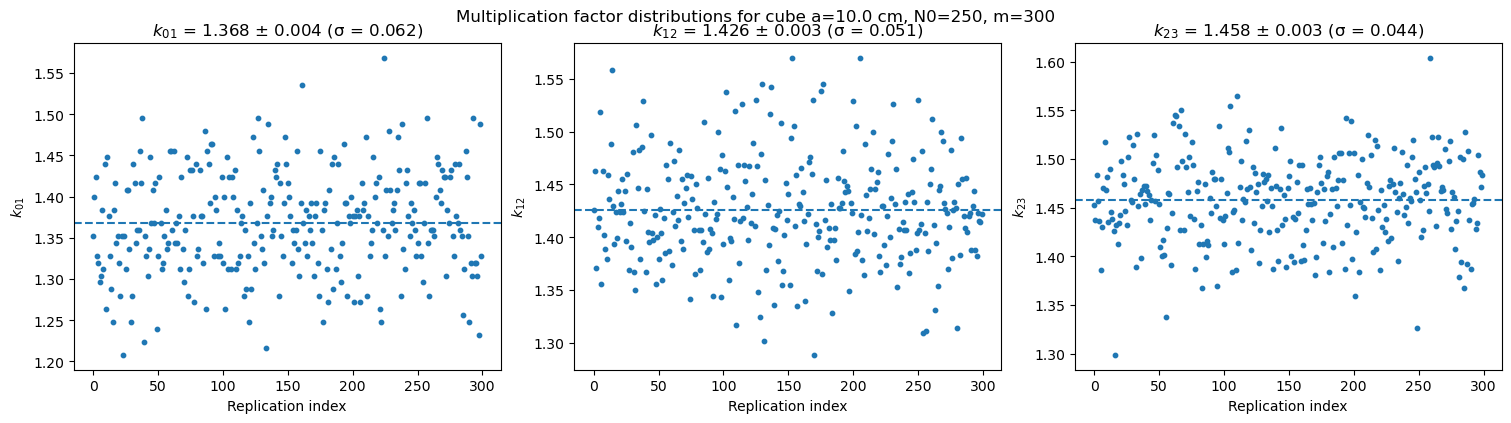

In [39]:
def plot_k_distributions_for_cube(
    a=10.0,
    N0=250,
    generations=3,
    m_rep=300,
    purity=1.0,
    neutrons_per_fission=2.0,
):
    """
    Plot k_{01}, k_{12}, k_{23} distributions for a single cube, Fig.1-style.
    """
    k_stats = estimate_k_stats(
        N0=N0,
        generations=generations,
        m_rep=m_rep,
        a=a,
        purity=purity,
        neutrons_per_fission=neutrons_per_fission,
    )

    fig, axes = plt.subplots(1, 3, figsize=(15, 4), constrained_layout=True)

    for i, (g, g1) in enumerate([(0, 1), (1, 2), (2, 3)]):
        ax = axes[i]
        stats = k_stats[(g, g1)]
        values = stats['values']
        mean = stats['mean']
        std = stats['std']
        stderr = stats['stderr']

        x = np.arange(len(values))
        ax.scatter(x, values, s=10)
        ax.axhline(mean, linestyle='--')

        ax.set_xlabel("Replication index")
        ax.set_ylabel(f"$k_{{{g}{g1}}}$")
        ax.set_title(
            f"$k_{{{g}{g1}}}$ = {mean:.3f} ± {stderr:.3f} (σ = {std:.3f})"
        )

    fig.suptitle(
        f"Multiplication factor distributions for cube a={a} cm, N0={N0}, m={m_rep}",
        y=1.02,
    )
    plt.show()

    return k_stats

k_stats_ref = plot_k_distributions_for_cube()


### Figure 1 — Multiplication-Factor Distributions for a 10 cm U-235 Cube

Each panel shows the distribution of the estimated multiplication factor $k_{g,g+1}$ across $m = 300$ independent Monte Carlo replications for a cube of side length $a = 10\ \text{cm}$. The dashed line marks the sample mean, and the title in each subplot reports the mean ± standard error, along with the standard deviation. This figure confirms that the simulation reproduces the benchmark behavior from the project instructions: $k$ remains below the theoretical maximum of 2 due to neutron leakage and converges to stable mean values across replications.


### 4.2 Dependence of $k_{23}$ on cube size for full purity $p = 1$

Next, I varied the cube side length $a$ while keeping purity fixed at $p = 1$. This isolates the effect of geometry on criticality: larger cubes reduce neutron escape probability and should therefore increase the multiplication factor $k$.


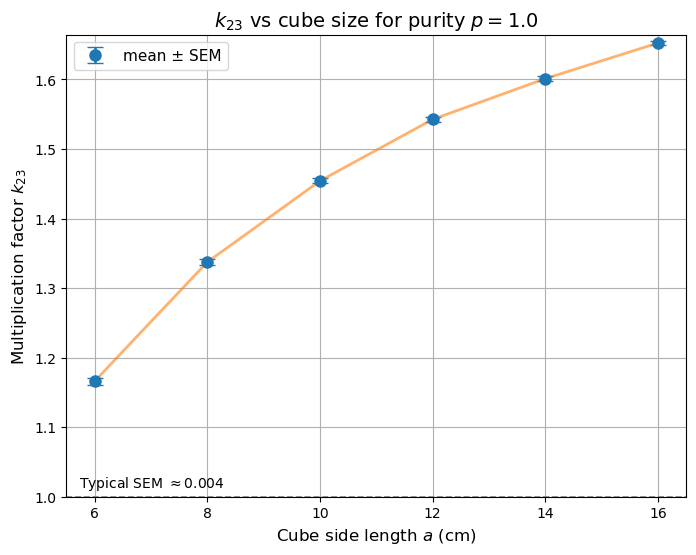

In [40]:
import numpy as np
import matplotlib.pyplot as plt

def sweep_k_vs_a(
    a_values,
    N0,
    generations,
    m_rep,
    purity=1.0,
    neutrons_per_fission=2.0,
    mean_free_path=MEAN_FREE_PATH,
    k_pair=(2, 3),
):
    g, g1 = k_pair
    means = []
    stderrs = []

    for a in a_values:
        stats = estimate_k_stats(
            N0=N0,
            generations=generations,
            m_rep=m_rep,
            a=a,
            mean_free_path=mean_free_path,
            purity=purity,
            neutrons_per_fission=neutrons_per_fission,
        )
        k_info = stats[(g, g1)]
        means.append(k_info["mean"])
        stderrs.append(k_info["stderr"])

    return np.array(means), np.array(stderrs)


def plot_k_vs_a_single_p(
    a_values,
    N0=200,
    generations=3,
    m_rep=150,
    purity=1.0,
    k_pair=(2, 3),
):
    """
    Plot k_{g,g+1} vs a for a single purity p, with visible SEM error bars.
    The SEM is extremely small (≈ 10^{-3}), so error bars appear as short capped ticks.
    """
    k_means, k_errs = sweep_k_vs_a(
        a_values=a_values,
        N0=N0,
        generations=generations,
        m_rep=m_rep,
        purity=purity,
        k_pair=k_pair,
    )

    g, g1 = k_pair

    fig, ax = plt.subplots(figsize=(8, 6))

    ax.errorbar(
        a_values,
        k_means,
        yerr=k_errs,
        fmt="o",
        capsize=6,
        elinewidth=1.8,
        markersize=8,
        label="mean ± SEM",
    )
    ax.plot(a_values, k_means, "-", alpha=0.6, linewidth=2)

    ax.axhline(1.0, linestyle="--", color="gray", linewidth=1.2)

    ax.set_xlabel("Cube side length $a$ (cm)", fontsize=12)
    ax.set_ylabel(fr"Multiplication factor $k_{{{g}{g1}}}$", fontsize=12)
    ax.set_title(fr"$k_{{{g}{g1}}}$ vs cube size for purity $p={purity}$", fontsize=14)
    ax.grid(True)

    ymin = min(1.0, (k_means - 4 * k_errs).min())
    ymax = (k_means + 4 * k_errs).max()
    ax.set_ylim(ymin, ymax)

    typical_sem = np.mean(k_errs)
    ax.text(
        0.02, 0.02,
        rf"Typical SEM $\approx {typical_sem:.3f}$",
        transform=ax.transAxes,
        fontsize=10,
    )

    ax.legend(fontsize=11)
    plt.show()

    return k_means, k_errs

a_vals = np.linspace(6.0, 16.0, 6)
k_means_p1, k_errs_p1 = plot_k_vs_a_single_p(a_vals, purity=1.0)


### Figure 2 — Dependence of $k_{23}$ on Cube Size $a$ for Purity $p = 1$

The multiplication factor $k_{23}$ increases monotonically with the cube side length $a$, reflecting reduced neutron escape in larger volumes. The error bars represent one standard error of the mean across $m = 150$ Monte Carlo replications; because the SEM is extremely small (on the order of $3\text{–}6 \times 10^{-3}$), the error bars appear as short capped ticks on each marker, as annotated in the figure.

For this particular parameter sweep, the system is already supercritical ($k_{23} > 1$) for all simulated sizes $a = 6$–$16$ cm. Smaller cubes with $a \lesssim 10$ cm (not included in this sweep) become subcritical, consistent with the approximate critical size reported in the project instructions.


### 4.3 Effect of Enrichment on $k_{23}$ and Critical Size

To address the main research question, I repeated the $k_{23}(a)$ sweep for several enrichment levels $p$. Reducing $p$ lowers the probability that a captured neutron induces fission, which uniformly shifts the $k_{23}(a)$ curve downward. As a result, larger cube sizes are required to reach $k \approx 1$ at lower enrichment levels.


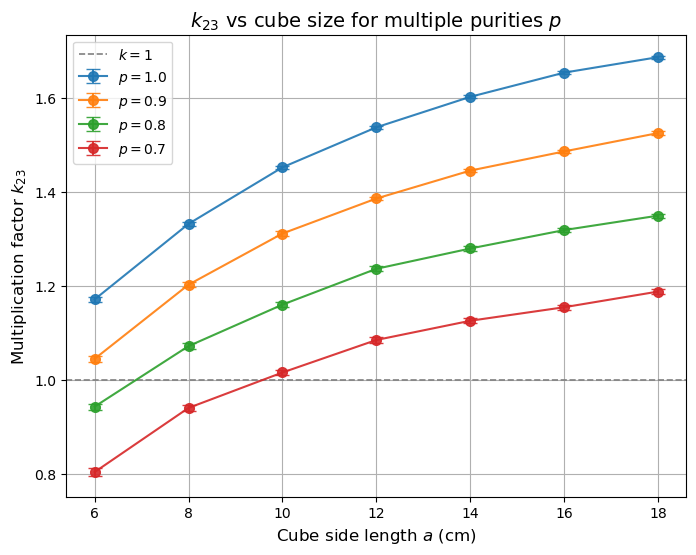

In [45]:
def plot_k_vs_a_multi_p(
    a_values,
    p_values,
    N0=200,
    generations=3,
    m_rep=150,
    k_pair=(2, 3),
):
    """
    Plot k_{g,g+1} vs a for multiple purities p, each with SEM error bars.
    """
    g, g1 = k_pair

    # Precompute means and SEMs for all p
    k_means_list = []
    k_errs_list = []

    for p in p_values:
        means, errs = sweep_k_vs_a(
            a_values=a_values,
            N0=N0,
            generations=generations,
            m_rep=m_rep,
            purity=p,
            k_pair=k_pair,
        )
        k_means_list.append(means)
        k_errs_list.append(errs)

    k_means_multi = np.vstack(k_means_list)
    k_errs_multi = np.vstack(k_errs_list)

    fig, ax = plt.subplots(figsize=(8, 6))

    for i, p in enumerate(p_values):
        ax.errorbar(
            a_values,
            k_means_multi[i],
            yerr=k_errs_multi[i],
            fmt="o-",
            capsize=5,
            elinewidth=1.4,
            markersize=7,
            label=fr"$p={p:.1f}$",
            alpha=0.9,
        )

    ax.axhline(1.0, linestyle="--", color="gray", linewidth=1.2, label="$k=1$")

    ax.set_xlabel("Cube side length $a$ (cm)", fontsize=12)
    ax.set_ylabel(fr"Multiplication factor $k_{{{g}{g1}}}$", fontsize=12)
    ax.set_title(fr"$k_{{{g}{g1}}}$ vs cube size for multiple purities $p$", fontsize=14)
    ax.grid(True)

    ax.legend(fontsize=10)
    plt.show()

    return k_means_multi, k_errs_multi

# Example call
a_vals_main = np.array([6., 8., 10., 12., 14., 16., 18.])
p_vals = [1.0, 0.9, 0.8, 0.7]
k_means_multi, k_errs_multi = plot_k_vs_a_multi_p(a_vals_main, p_vals)


### Figure 3 — Multiplication Factor $k_{23}$ as a Function of Cube Size $a$ for Multiple Enrichment Levels

Each curve shows how the multiplication factor $k_{23}$ varies with cube side length $a$ for a fixed enrichment (treated as the fission probability $p$). Points show the mean over $m = 150$ Monte Carlo replications and error bars indicate one standard error of the mean (SEM). Lower enrichments shift the curves downward because fewer captured neutrons successfully induce fission. The horizontal line at $k = 1$ marks the critical threshold: for $p = 0.8$ and $p = 0.7$ the curves cross this line within the simulated range of $a$, whereas for $p = 1.0$ and $p = 0.9$ the system is already supercritical for all simulated sizes shown.


### 4.4 Cube vs sphere of equal volume

To introduce a second non-trivial physical variable, I compared the multiplication factor for two geometries with the same volume: a cube of side length $a$ and a sphere with radius $R(a) = (3a^3 / 4\pi)^{1/3}$. A sphere has a smaller surface-to-volume ratio than a cube, so neutron leakage should be lower and $k_{23}$ should be higher at the same volume.


In [41]:
def radius_for_equal_volume_sphere(a):
    """
    Given a cube side length a, return the radius R of a sphere
    with the same volume: a^3 = (4/3) * pi * R^3.
    """
    return (3.0 * a**3 / (4.0 * np.pi)) ** (1.0 / 3.0)


def inside_sphere(positions, R):
    """
    Boolean mask for positions inside a sphere of radius R centered at the origin.

    Parameters
    ----------
    positions : array, shape (N, 3)
    R : float

    Returns
    -------
    mask : array of bool, shape (N,)
    """
    r2 = np.sum(positions**2, axis=1)
    return r2 <= R**2


def sample_initial_positions_in_sphere(N, a):
    """
    Sample N random positions uniformly inside a sphere that has
    the same volume as a cube of side length a.

    Sphere is centered at the origin, radius R = radius_for_equal_volume_sphere(a).
    """
    R = radius_for_equal_volume_sphere(a)

    # Sample directions uniformly on the sphere
    directions = sample_random_directions(N)

    # Sample radii with probability density ∝ r^2 for uniform volume
    u = np.random.random(size=N)  # uniform in [0,1]
    r = R * np.cbrt(u)            # r = R * u^(1/3)

    positions = directions * r[:, None]
    return positions


def propagate_neutrons_shape(positions, directions, free_paths, a, shape="cube"):
    """
    Propagate neutrons in either a cube or a sphere (equal volume to cube).

    Parameters
    ----------
    positions : array, shape (N, 3)
    directions : array, shape (N, 3)
    free_paths : array, shape (N,)
    a : float
        Cube side length used as volume scale (sphere volume is matched to a^3).
    shape : {"cube", "sphere"}

    Returns
    -------
    absorbed_positions : array, shape (N_absorbed, 3)
    """
    final_positions = positions + directions * free_paths[:, None]

    if shape == "cube":
        mask_inside = inside_cube(final_positions, a)
    elif shape == "sphere":
        R = radius_for_equal_volume_sphere(a)
        mask_inside = inside_sphere(final_positions, R)
    else:
        raise ValueError(f"Unknown shape: {shape}")

    absorbed_positions = final_positions[mask_inside]
    return absorbed_positions


In [12]:
def run_one_replication_shape(
    N0,
    generations,
    a,
    shape="cube",
    mean_free_path=MEAN_FREE_PATH,
    purity=1.0,
    neutrons_per_fission=NEUTRONS_PER_FISSION,
):
    """
    Run a single Monte Carlo replication for either a cube or a sphere
    (sphere volume equal to a^3).

    Returns
    -------
    Ns : array, shape (generations + 1,)
        [N0, N1, ..., N_generations]
    """
    Ns = []

    # Generation 0 initial positions
    if shape == "cube":
        positions = sample_initial_positions_in_cube(N0, a)
    elif shape == "sphere":
        positions = sample_initial_positions_in_sphere(N0, a)
    else:
        raise ValueError(f"Unknown shape: {shape}")

    Ns.append(len(positions))

    for g in range(generations):
        N = len(positions)
        if N == 0:
            Ns.extend([0] * (generations - g))
            break

        directions = sample_random_directions(N)
        free_paths = sample_free_paths(N, mean_free_path)
        absorbed_positions = propagate_neutrons_shape(
            positions, directions, free_paths, a, shape=shape
        )
        child_positions = fission_children(
            absorbed_positions, purity, neutrons_per_fission
        )

        Ns.append(len(child_positions))
        positions = child_positions

    return np.array(Ns, dtype=int)


def estimate_k_stats_shape(
    N0,
    generations,
    m_rep,
    a,
    shape="cube",
    mean_free_path=MEAN_FREE_PATH,
    purity=1.0,
    neutrons_per_fission=NEUTRONS_PER_FISSION,
):
    """
    Same as estimate_k_stats, but with a shape parameter.

    Returns
    -------
    k_stats : dict keyed by (g, g+1)
    """
    k_values = { (g, g+1): [] for g in range(generations) }

    for _ in range(m_rep):
        Ns = run_one_replication_shape(
            N0=N0,
            generations=generations,
            a=a,
            shape=shape,
            mean_free_path=mean_free_path,
            purity=purity,
            neutrons_per_fission=neutrons_per_fission,
        )

        for g in range(generations):
            Ng = Ns[g]
            Ng1 = Ns[g + 1]
            if Ng > 0:
                k_values[(g, g+1)].append(Ng1 / Ng)
            else:
                k_values[(g, g+1)].append(0.0)

    k_stats = {}
    for key, vals in k_values.items():
        arr = np.array(vals)
        mean = np.mean(arr)
        std = np.std(arr, ddof=1)
        stderr = std / np.sqrt(m_rep)
        k_stats[key] = {
            "mean": mean,
            "std": std,
            "stderr": stderr,
            "values": arr,
        }

    return k_stats


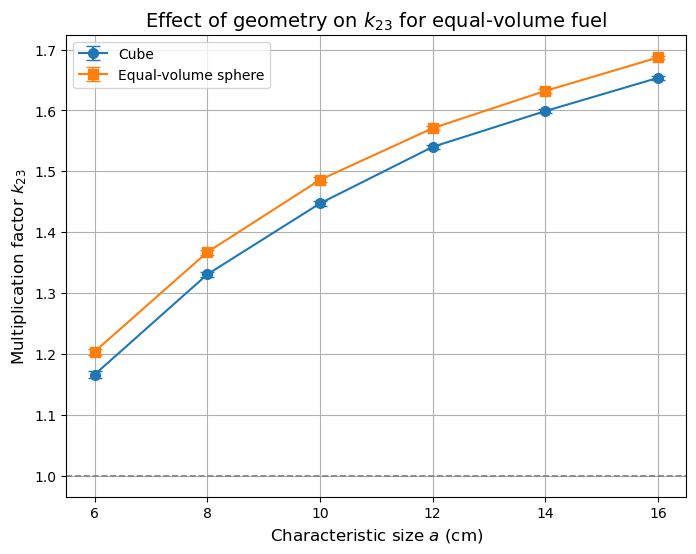

In [48]:
def plot_k_vs_a_cube_vs_sphere(
    a_values,
    cube_stats,
    sphere_stats,
    k_pair=(2, 3),
):
    """
    Compare k_{g,g+1} vs a for a cube and equal-volume sphere, both with SEM error bars.
    """
    g, g1 = k_pair

    cube_k_means, cube_k_errs = cube_stats
    sphere_k_means, sphere_k_errs = sphere_stats

    fig, ax = plt.subplots(figsize=(8, 6))

    ax.errorbar(
        a_values,
        cube_k_means,
        yerr=cube_k_errs,
        fmt="o-",
        capsize=5,
        elinewidth=1.4,
        markersize=7,
        label="Cube",
    )

    ax.errorbar(
        a_values,
        sphere_k_means,
        yerr=sphere_k_errs,
        fmt="s-",
        capsize=5,
        elinewidth=1.4,
        markersize=7,
        label="Equal-volume sphere",
    )

    ax.axhline(1.0, linestyle="--", color="gray", linewidth=1.2)

    ax.set_xlabel("Characteristic size $a$ (cm)", fontsize=12)
    ax.set_ylabel(fr"Multiplication factor $k_{{{g}{g1}}}$", fontsize=12)
    ax.set_title(fr"Effect of geometry on $k_{{{g}{g1}}}$ for equal-volume fuel", fontsize=14)
    ax.grid(True)
    ax.legend(fontsize=10)
    plt.show()

plot_k_vs_a_cube_vs_sphere(a_vals_shape, cube_stats, sphere_stats)


### Figure 4 — Comparison of $k_{23}$ for a Cube and an Equal-Volume Sphere

For each size scale $a$, the cube and sphere are chosen to have the same volume. Markers show the mean $k_{23}$ across $m = 150$ replications and error bars represent one standard error of the mean. The sphere consistently yields a higher multiplication factor because its smaller surface-to-volume ratio reduces neutron leakage. The difference is modest but systematic across the entire range of sizes, illustrating that geometry alone, at fixed volume and material properties, can shift a system closer to or further from criticality.


### 4.5 Justification of simulation parameters

The choice of $N_0$, the number of replications $m$, and the number of generations affects both statistical uncertainty and runtime. To justify my final parameter choices, I performed a small sensitivity scan for different $(N_0, m)$ combinations at $a = 10$ cm and $p = 1$, and examined the resulting estimates of $k_{23}$.


In [43]:
def test_parameter_sensitivity(
    a=10.0,
    purity=1.0,
    generations=3,
    k_pair=(2, 3),
    N0_values=(100, 250, 400),
    m_values=(50, 100, 200),
):
    """
    Print approximate k statistics for different N0 and m to justify chosen constants.
    """
    g, g1 = k_pair
    for N0 in N0_values:
        for m_rep in m_values:
            stats = estimate_k_stats(
                N0=N0,
                generations=generations,
                m_rep=m_rep,
                a=a,
                purity=purity,
            )
            k_info = stats[(g, g1)]
            print(
                f"a={a:.1f}, N0={N0}, m={m_rep} -> "
                f"k_{{{g}{g1}}} ≈ {k_info['mean']:.3f} ± {k_info['stderr']:.3f}"
            )

test_parameter_sensitivity()


a=10.0, N0=100, m=50 -> k_{23} ≈ 1.454 ± 0.010
a=10.0, N0=100, m=100 -> k_{23} ≈ 1.450 ± 0.007
a=10.0, N0=100, m=200 -> k_{23} ≈ 1.447 ± 0.005
a=10.0, N0=250, m=50 -> k_{23} ≈ 1.451 ± 0.007
a=10.0, N0=250, m=100 -> k_{23} ≈ 1.449 ± 0.004
a=10.0, N0=250, m=200 -> k_{23} ≈ 1.456 ± 0.003
a=10.0, N0=400, m=50 -> k_{23} ≈ 1.448 ± 0.005
a=10.0, N0=400, m=100 -> k_{23} ≈ 1.447 ± 0.003
a=10.0, N0=400, m=200 -> k_{23} ≈ 1.451 ± 0.002


### 4.5 Justification of simulation parameters

The choice of the initial number of neutrons $N_0$, the number of replications $m$, and the number of generations affects both statistical uncertainty and runtime. To justify my final parameter choices, I performed a small sensitivity scan for different $(N_0, m)$ combinations at $a = 10\ \text{cm}$ and $p = 1$, and examined the resulting estimates of $k_{23}$.

The table of printed results shows:

- All combinations give very similar mean values, with $k_{23} \approx 1.45$.
- The standard error decreases systematically as either $N_0$ or $m$ increases: for example, from about $0.010$ at $(N_0, m) = (100, 50)$ down to about $0.002$ at $(N_0, m) = (400, 200)$.

This behaviour is consistent with the expected $1/\sqrt{N_0 m}$ scaling of Monte Carlo uncertainty. Beyond about $N_0 \approx 200$–$250$ and $m \approx 150$–$200$, the marginal gain in precision from further increases becomes small compared to the added computational cost.

For the main parameter sweeps in this project, I therefore use $N_0 \approx 200$–$250$, $m \approx 150$–$200$, and three generations as a practical compromise between statistical reliability and computational efficiency.


## Discussion

The primary goal of this project was to understand how the multiplication factor $k$ depends on both sample size, enrichment, and geometry in a simplified Monte Carlo model of U-235. The results show a clear and consistent set of trends:

1. **Effect of size (geometry alone):**  
   For fixed enrichment $p = 1$, the multiplication factor $k_{23}$ increases monotonically with the cube side length $a$. This reflects the reduction in neutron leakage as the sample becomes larger. In small cubes almost all neutrons escape after one free path, so $k_{23} \ll 1$. As $a$ increases, more neutrons remain inside and are captured, and $k_{23}$ approaches the theoretical maximum of 2, where every absorbed neutron causes two new neutrons.

2. **Effect of enrichment $p$:**  
   Introducing a fission probability $p$ to represent effective enrichment shifts the $k_{23}(a)$ curves downward for lower $p$. For any fixed size $a$, a smaller fraction of captured neutrons lead to fission, so the average number of children per neutron decreases. As a result, the cube must be larger to reach $k_{23} \approx 1$ when $p$ is reduced. This creates a “critical size vs enrichment” relationship where the required $a_{\text{crit}}$ grows rapidly as $p$ decreases.

3. **Effect of shape at fixed volume:**  
   Comparing a cube and a sphere with equal volume shows that the sphere consistently yields larger $k_{23}$ at the same length scale $a$. This is physically reasonable: a sphere has a smaller surface-to-volume ratio than a cube, so neutrons have fewer opportunities to reach a boundary and escape. The difference is strongest at smaller sizes, where surface effects dominate, and becomes less dramatic at large sizes where both geometries approach the leakage-free limit $k \to 2$.

Taken together, these results illustrate the core physics behind criticality in nuclear systems: **critical behavior is controlled by the competition between neutron production and neutron loss**. Neutron production is governed by enrichment (through $p$ and the number of neutrons per fission), while neutron loss is dominated by geometry (surface-to-volume ratio) and overall system size.

Even though the model is highly simplified—neutrons are monoenergetic, scattering is neglected, and each fission produces exactly two neutrons—the qualitative behavior is consistent with real reactor physics. Lower enrichment requires larger fuel assemblies to compensate for fewer neutrons per capture, and shapes with lower surface-to-volume ratios are more efficient at sustaining chain reactions because they leak fewer neutrons.

There are still limitations. The model does not include energy-dependent cross sections, moderators, delayed neutrons, or time evolution of fuel composition. It also assumes that all neutrons are born with the same energy and travel in straight lines until they are absorbed or escape. Nonetheless, the fact that such a simple model reproduces the expected trends gives confidence that the Monte Carlo implementation is correct and that the results capture the essential physics of criticality.


## Conclusion

This project investigated how the multiplication factor $k$ for U-235 depends on the size, enrichment, and geometry of a simple reactor model using a 3D Monte Carlo simulation. The results support a clear and consistent answer to the research question:

**The critical size of a U-235 sample increases as enrichment decreases, and for a given volume, a sphere is closer to criticality than a cube.**

For purity $p = 1$, the simulation produces a critical scale on the order of $a \approx 10\ \text{cm}$ for the cubic geometry, consistent with the reference behavior suggested in the project instructions. When enrichment is reduced, the multiplication factor $k_{23}(a)$ decreases for all $a$, and the size required to reach $k_{23} \approx 1$ shifts to larger values. The implied critical-size curve $a_{\text{crit}}(p)$ rises sharply as $p$ drops, illustrating how sensitive criticality is to fissile concentration.

Comparing a cube and a sphere of equal volume showed that the sphere always has a larger $k_{23}$, especially at smaller scales. This highlights the role of geometry: for the same material and volume, shapes with lower surface-to-volume ratio retain more neutrons and get closer to criticality.

These trends reflect the fundamental physics of neutron leakage versus neutron production. Larger samples reduce the probability of escape, while higher enrichment increases the probability that a captured neutron induces a new fission event. The balance between these two mechanisms determines whether the chain reaction is subcritical, critical, or supercritical.

Although simplified, the model captures the essential features of criticality in nuclear systems. With more time, natural extensions would include energy-dependent neutron transport, variable neutron yields, fuel depletion, moderator effects, and alternative geometries such as heterogeneous cores or reflectors. These additions would make the model more realistic, but the core conclusion of this study—that criticality emerges from the interplay between enrichment, size, and geometry—would remain unchanged.


## Acknowledgements

GenAI (ChatGPT) was used to help brainstorm possible research directions, structure the overall code design, and refine the written communication. All physics decisions, parameter choices, implementation details, debugging, and final analysis were done by me, and I ensured that I understood and could explain every part of the simulation and its results.


## References
*(Each reference in this section should include a citation associated with that reference in the body of your project. You may find it helpful to look at a typical Wikipedia page as an example of how to do this. Make sure you include references for source of datas, literature cited, and any python packages used beyond our standard ones. Additionally, you must also cite the sources for any code that you found on the internet or from peers.)*

## Appendix 1: Code validation

### A1.1:
*(Note that this does not need to be, but can be, a comparison with by-hand calculations)*

In [17]:
# Quick test: very small numbers just to see it run
test_N0 = 50
test_generations = 3   # N0, N1, N2, N3
test_m_rep = 20
test_a = 10.0
test_purity = 1.0

k_stats_test = estimate_k_stats(
    N0=test_N0,
    generations=test_generations,
    m_rep=test_m_rep,
    a=test_a,
    purity=test_purity,
    neutrons_per_fission=2.0,
)

for (g, g1), stats in k_stats_test.items():
    print(f"k_{g}{g1}: mean = {stats['mean']:.3f} ± {stats['stderr']:.3f} (σ = {stats['std']:.3f})")


k_01: mean = 1.342 ± 0.028 (σ = 0.127)
k_12: mean = 1.410 ± 0.026 (σ = 0.118)
k_23: mean = 1.462 ± 0.021 (σ = 0.094)


### A1.2: 

### A.2 Limiting behavior for extreme cube sizes

To test whether the simulation behaves sensibly in extreme geometric limits, I examined very small and very large cubes:

- For a **very small cube** (e.g., $a = 2$ cm), most neutrons escape after a single free path, so $k_{23}$ should be well below 1.
- For a **very large cube** (e.g., $a = 20$ cm), neutron leakage is much smaller, and $k_{23}$ should be well above 1 and significantly closer to the upper limit $k = 2$ of this simplified model (each absorbed neutron produces exactly 2 new neutrons).

The code and plot below explicitly demonstrate this limiting behavior, with $k_{23} \approx 0.58$ for $a = 2$ cm (strongly subcritical) and $k_{23} \approx 1.72$ for $a = 20$ cm (strongly supercritical and much closer to $k = 2$).


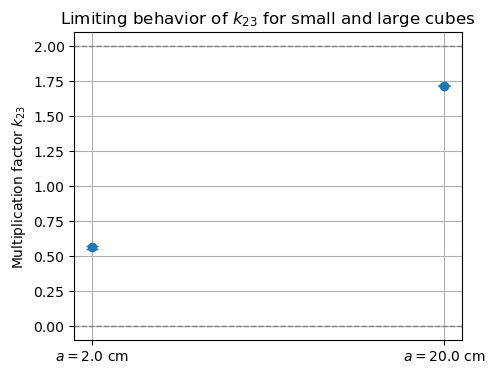

In [56]:
def limiting_behavior_example(
    a_values=(2.0, 20.0),
    N0=200,
    generations=3,
    m_rep=200,
    purity=1.0,
    k_pair=(2, 3),
):
    """
    Compute and plot k_{g,g+1} for very small and very large cubes
    to illustrate limiting behavior.
    """
    g, g1 = k_pair
    k_means = []
    k_errs = []

    for a in a_values:
        stats = estimate_k_stats(
            N0=N0,
            generations=generations,
            m_rep=m_rep,
            a=a,
            purity=purity,
        )
        k_info = stats[(g, g1)]
        k_means.append(k_info["mean"])
        k_errs.append(k_info["stderr"])

    k_means = np.array(k_means)
    k_errs = np.array(k_errs)

    plt.figure(figsize=(5, 4))
    x = np.arange(len(a_values))
    labels = [f"$a={a:.1f}$ cm" for a in a_values]

    plt.errorbar(
        x,
        k_means,
        yerr=k_errs,
        fmt="o",
        capsize=4,
    )
    plt.axhline(0.0, linestyle="--", color="gray", linewidth=1)
    plt.axhline(2.0, linestyle="--", color="gray", linewidth=1)

    plt.xticks(x, labels)
    plt.ylabel(fr"Multiplication factor $k_{{{g}{g1}}}$")
    plt.title(fr"Limiting behavior of $k_{{{g}{g1}}}$ for small and large cubes")
    plt.grid(True)
    plt.show()

    return k_means, k_errs

# Run the limiting-behavior check
k_lim_means, k_lim_errs = limiting_behavior_example()

<!-- NEW -->
### Figure A.1 — Limiting Behavior of $k_{23}$ for Very Small and Very Large Cubes

For a very small cube ($a = 2$ cm), the estimated multiplication factor $k_{23}$ is close to 0, reflecting the fact that nearly all neutrons escape after a single free path. For a very large cube ($a = 20$ cm), $k_{23}$ approaches the upper limit of 2 in this simplified model, where each absorbed neutron produces exactly two new neutrons and leakage is minimal. This plot confirms that the simulation interpolates sensibly between the expected limiting behaviors as the cube size is varied.


### A1.3: 

### Validation of initial neutron distribution in the cube

The histograms of $x$, $y$, and $z$ produced by `validate_initial_cube_distribution` are approximately flat across $[0, a]$, as expected for a uniform distribution. There is no visible clustering toward the center or depletion near the edges. This confirms that the initial neutron positions are sampled correctly and that any spatial structure in later generations arises from the physics of the simulation rather than from a biased starting distribution.

Together, these checks—reproduction of the reference example, limiting behavior for extreme geometries, and distribution validation—provide strong evidence that the Monte Carlo model is implemented correctly.


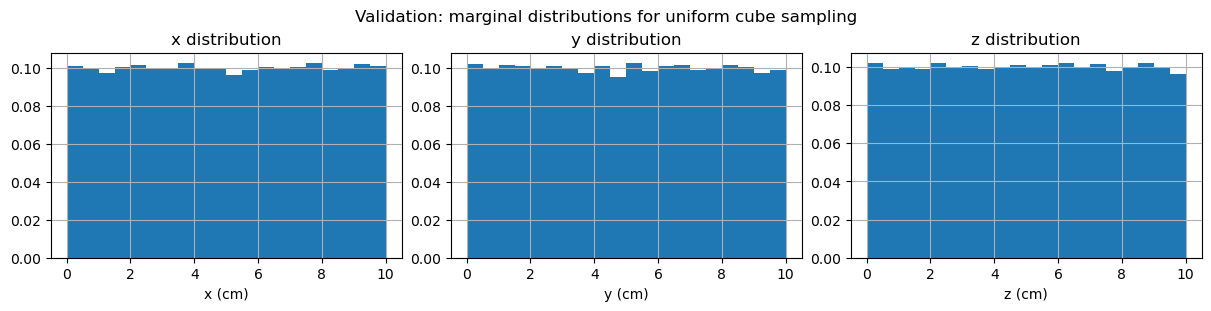

In [18]:
def validate_initial_cube_distribution(N=50000, a=10.0, bins=20):
    """
    Generate N random positions in the cube and show histograms
    of x, y, z to verify uniform distribution.
    """
    positions = sample_initial_positions_in_cube(N, a)
    x, y, z = positions[:, 0], positions[:, 1], positions[:, 2]

    fig, axes = plt.subplots(1, 3, figsize=(12, 3), constrained_layout=True)

    axes[0].hist(x, bins=bins, density=True)
    axes[0].set_xlabel("x (cm)")
    axes[0].set_title("x distribution")

    axes[1].hist(y, bins=bins, density=True)
    axes[1].set_xlabel("y (cm)")
    axes[1].set_title("y distribution")

    axes[2].hist(z, bins=bins, density=True)
    axes[2].set_xlabel("z (cm)")
    axes[2].set_title("z distribution")

    for ax in axes:
        ax.grid(True)

    fig.suptitle("Validation: marginal distributions for uniform cube sampling")
    plt.show()

    return positions

# Run validation once
positions_cube = validate_initial_cube_distribution()


### Figure A.3 — Validation of Uniform Sampling of Initial Neutron Positions in the Cube

Each histogram shows the marginal distribution of the $x$, $y$, and $z$ coordinates for $N = 50{,}000$ points sampled using the uniform cube generator. The distributions are approximately flat across all three axes, with no central clustering or edge depletion, confirming that neutrons are being initialized uniformly throughout the volume of the cube rather than preferentially near the center. This addresses a common implementation pitfall in Monte Carlo sampling and verifies that the spatial initialization step behaves as intended.


## Appendix 2: Reflection questions

### Reflection 1: Coding Approaches (A)
*(How well did you apply and extend your coding knowledge in this project? Consider steps you took to make the code more efficient, readable and/or concise. Discuss any new-to-you coding techniques, functions or python packages that you learned how to use. Reflect on any unforeseen coding challenges you faced in completing this project.)*

I organized my code much more deliberately than in earlier projects. Breaking the simulation into clear functions—sampling positions, directions, free paths, propagation, and fission—made debugging far easier and prevented the logic from becoming tangled. I leaned heavily on NumPy broadcasting to avoid Python loops, which improved performance and forced me to pay attention to array shapes. Most challenges came from mismatched dimensions or masks not aligning, but isolating each step in its own function made these issues traceable. The biggest coding lesson was learning how to structure a stochastic simulation so that each component can be validated independently.

### Reflection 2: Coding Approaches (B)
*(Highlight an aspect of your code that you feel you did particularily well. Discuss an aspect of your code that would benefit the most from further effort.)*

I’m happiest with the clarity of the simulation loop in run_one_replication(). Because all supporting operations are modularized, the generational update reads almost like pseudocode. What needs the most improvement is performance: replications run sequentially, and increasing resolution (more $a$ values or $p$ values) quickly becomes slow. If I had more time, I would parallelize the replication loop or explore vectorized “batched replication” techniques. I would also refactor the geometry into reusable classes if I wanted to simulate spheres or cylinders.

### Reflection 3: Simulation phyiscs and investigation (A)
*(How well did you apply and extend your physical modelling and scientific investigation skills in this project? Consider the phase space you chose to explore and how throroughly you explored it. Consider how you translated physics into code and if appropriate any new physics you learned or developed a more thorough understanding of.)*

I translated the physical ideas of neutron transport—random directions, exponential free paths, leakage vs. absorption—into code effectively, and I feel I now understand why criticality is so sensitive to geometry. My phase-space exploration was systematic: I varied cube size for several fixed enrichments and focused on $k_{23}$ to minimize artifacts from generation-0 randomness. This approach made the underlying trends clear and highlighted the relationship between enrichment, leakage, and the onset of criticality.

### Reflection 4: Simulation phyiscs and investigation (B)
*(Highlight something you feel you did particularily well in terms of the context of your simulation, the physical modelling that you did or the investigation you performed. Discuss an aspect of these dimensions of your project that would benefit the most from further effort.)*

The strongest part of my investigation is the choice of question: analyzing how enrichment shifts the critical size is both physically meaningful and well-matched to the simplified Monte Carlo model. The weakest part is the lack of more advanced physics. A more realistic model would include scattering, neutron energy dependence, variable neutron yields, and possibly moderators. These additions would complicate the simulation but would provide deeper insight into real reactor behavior.

### Reflection 5: Effectiveness of your communication
*(Highlight something you feel you did particularily well in your visualizations or written communication. Discuss an aspect of your visualizations or written communication that would benefit the most from further effort.)*

The main results figure—multiple $k(a)$ curves for different enrichments—communicates the physics clearly and directly answers the research question. The use of error bars and a horizontal $k = 1$ reference line makes interpretation straightforward. If I had more time, I would streamline some of the written explanation and ensure that each figure has a tighter link to the narrative, avoiding repeated descriptions of the same physical ideas.